In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

import mne
from mne.io import read_raw_egi

import mypy

In [2]:
cd C:\Users\Ola\Dropbox\Sarenka\warsztaty python\eeg

C:\Users\Ola\Dropbox\Sarenka\warsztaty python\eeg


In [3]:
pwd

'C:\\Users\\Ola\\Dropbox\\Sarenka\\warsztaty python\\eeg'

# Wczytujemy dane

In [4]:
fls = os.listdir()
fls

['grupa1warsztatyeeg 20160221.raw', 'grupa2warsztatyeeg 20160221.raw']

In [5]:
eeg = read_raw_egi(fls[0], preload=True)
eeg

Reading EGI header from grupa1warsztatyeeg 20160221.raw...
    Reading events ...
    Assembling measurement info ...
    Synthesizing trigger channel "STI 014" ...
    Excluding events {} ...
Reading 0 ... 104678  =      0.000 ...   418.712 secs...


<RawEGI  |  grupa1warsztatyeeg 20160221.raw, n_channels x n_times : 68 x 104679 (418.7 sec)>

# Zmagania z plotowaniem

In [6]:
%matplotlib qt
eeg.plot();

Using matplotlib backend: Qt4Agg


W komórce powyżej próbowaliśmy wyplotować dane, jednak oczom naszym ukazał się mrok i groza. Jak sobie z tym poradzić? Rozwiązanie jest całkiem proste, ale najpierw wyjaśnię z czego wynika problem. Niestety metoda `.plot()` nie skaluje domyślnie sygnału, więc w pewnych sytuacjach skala jest koszmarnie zła. Możemy jednak podać odpowiednią skalę jako słownik: `typ kanału -> skala`:

In [9]:
skala = {'eeg': 20}
eeg.plot(scalings=skala, show=False);

Ok, widzimy sygnał, trzeba go jednak jeszcze przefiltrować. Na zajęciach robiliśmy to krok po kroku, ale teraz zrobimy to na raz:

# Preprocessing - filtrowanie, dodawanie eventów, pozycji elektrod

In [10]:
eeg_flt = eeg.copy().filter(1, None).filter(53,47)

High-pass filtering at 1 Hz
Band-stop filtering from 47 - 53 Hz


In [13]:
eeg_flt.plot(scalings=skala, show=False);

In [14]:
# dodajemy eventy:
mypy.events.din2event(eeg_flt) # ta operacja jest in-place tzn. bez kopii

<RawEGI  |  grupa1warsztatyeeg 20160221.raw, n_channels x n_times : 65 x 104679 (418.7 sec)>

In [16]:
eeg_flt.info

<Info | 17 non-empty fields
    bads : 'list | 0 items
    buffer_size_sec : 'float | 1.0
    ch_names : 'list | EEG 001, EEG 002, EEG 003, EEG 004, EEG 005, EEG 006, ...
    chs : 'list | 65 items (EEG: 65)
    comps : 'list | 0 items
    custom_ref_applied : 'bool | False
    dev_head_t : 'mne.transforms.Transform | 3 items
    events : 'numpy.ndarray | 138 items
    filename : 'str | .../grupa1warsztatyeeg 20160221.raw
    highpass : 'float | 1.0 Hz
    hpi_meas : 'list | 0 items
    hpi_results : 'list | 0 items
    lowpass : 'float | 125.0 Hz
    meas_date : 'numpy.ndarray | 2016-02-21 12:18:24
    nchan : 'int | 65
    projs : 'list | 0 items
    sfreq : 'float | 250.0 Hz
    acq_pars : 'NoneType
    acq_stim : 'NoneType
    ctf_head_t : 'NoneType
    description : 'NoneType
    dev_ctf_t : 'NoneType
    dig : 'NoneType
    experimenter : 'NoneType
    file_id : 'NoneType
    hpi_subsystem : 'NoneType
    line_freq : 'NoneType
    meas_id : 'NoneType
    proj_id : 'NoneType
    p

In [18]:
eeg_flt.info['events'][:10,:]

array([[2992,    0,    8],
       [3722,    0,    4],
       [4453,    0,    8],
       [5186,    0,    8],
       [5914,    0,    8],
       [6649,    0,    4],
       [7374,    0,    4],
       [8117,    0,    8],
       [8840,    0,    4],
       [9561,    0,    4]])

In [26]:
# możemy wyplotować z informacją o wydarzeniach tak:
kolory = {4: 'g', 8: 'r'}
eeg_flt.plot(events=eeg_flt.info['events'], event_color=kolory, show=False, scalings=skala);

In [53]:
def plot_eeg(eeg):
    if isinstance(eeg, mne.io.Raw):
        eeg.plot(events=eeg.info['events'], event_color=kolory, show=False, scalings=skala)
    else:
        eeg.plot(show=False, scalings=skala)

In [27]:
# dodajemy pozycję elektrod
from mne.channels import read_montage

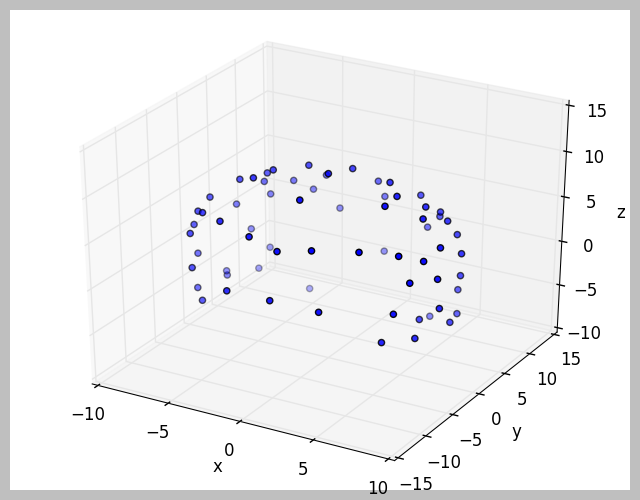

In [33]:
mntg = read_montage('GSN-HydroCel-65_1.0')
mntg.plot()

In [35]:
eeg_flt.set_montage(mntg)

ValueError: None of the sensors defined in the montage were found in the info structure. Check the channel names.

Niestety nazwy elektrod się nie zgadzają...
Musimy je zmienić - pomoże nam metoda `rename_channels` obiektu `Raw`:

In [37]:
map_names = {ch: 'E'+str(int(ch[-3:])) for ch in eeg_flt.ch_names[:-1]}
map_names['EEG 065'] = 'Cz'
for k in list(map_names.keys())[:5]:
    print('{}: {}'.format(k, map_names[k]))

EEG 018: E18
EEG 025: E25
EEG 055: E55
EEG 053: E53
EEG 052: E52


In [38]:
eeg_flt.rename_channels(map_names)

In [39]:
eeg_flt.set_montage(mntg)

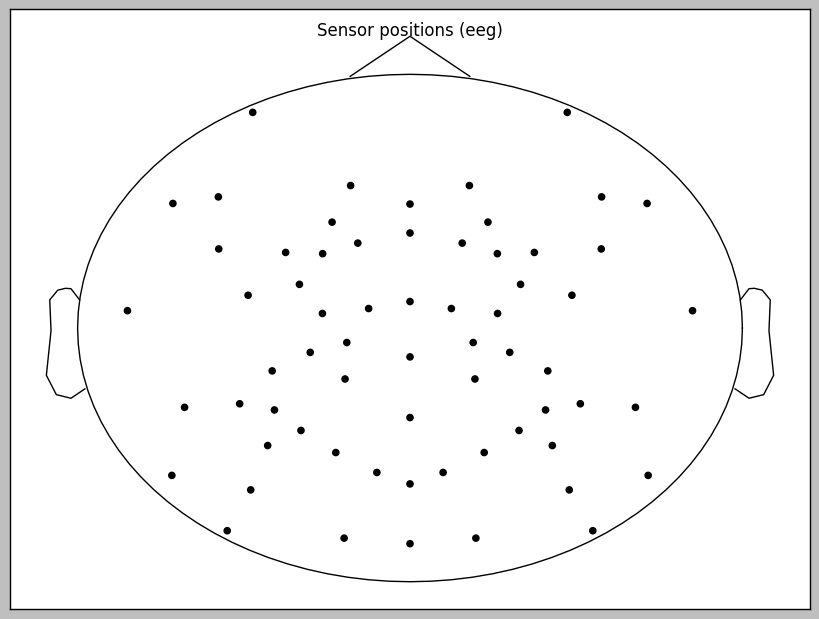

In [40]:
eeg_flt.plot_sensors(show=False)

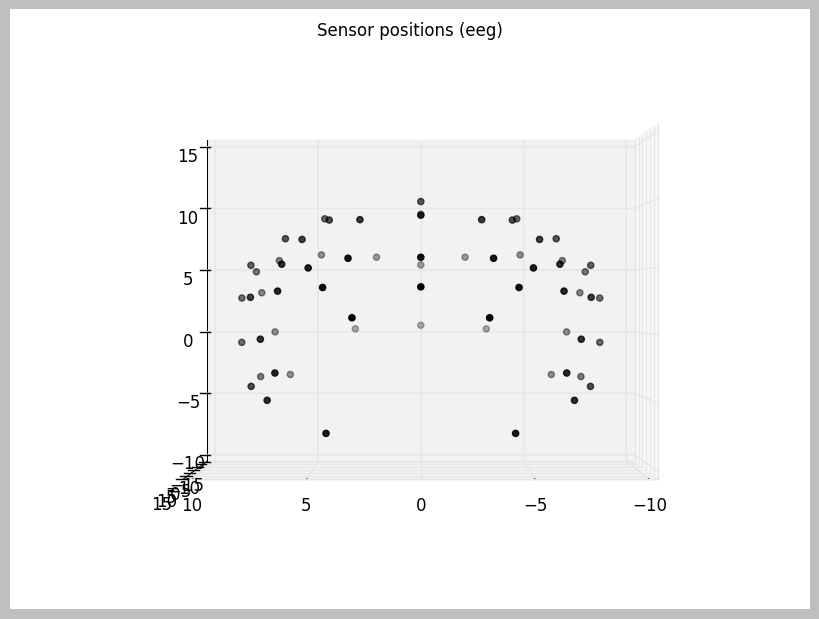

In [43]:
eeg_flt.plot_sensors(kind='3d', show=False)

# Preprocessing: epokowanie, odrzucanie epok, ica

In [44]:
ev_dict = {'face': 4, 'car': 8}
ep = mne.Epochs(eeg_flt, events=eeg_flt.info['events'], event_id=ev_dict, tmin=-0.25, tmax=0.75, preload=True)

138 matching events found
Applying baseline correction (mode: mean)
Adding average EEG reference projection.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 138 events and 251 original time points ...
0 bad epochs dropped


In [56]:
plot_eeg(ep)

Dropped 1 epoch
Channels marked as bad: []


Z opisu wyniżej wnioskujemy, że jedna epoka została usunięta. Czas na ica:

In [59]:
from mne.preprocessing import ICA
ica = ICA(method='extended-infomax')

In [60]:
ica.fit(ep)

Fitting ICA to data using 65 channels. 
Please be patient, this may take some time
Inferring max_pca_components from picks.
Using all PCA components: 65
computing Extended Infomax ICA


<ICA  |  epochs decomposition, fit (extended-infomax): 34387 samples, 65 components, channels used: "eeg">

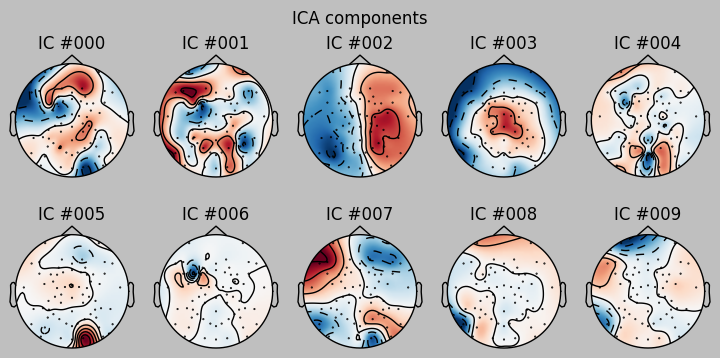

In [63]:
ica.plot_components(picks=range(10))

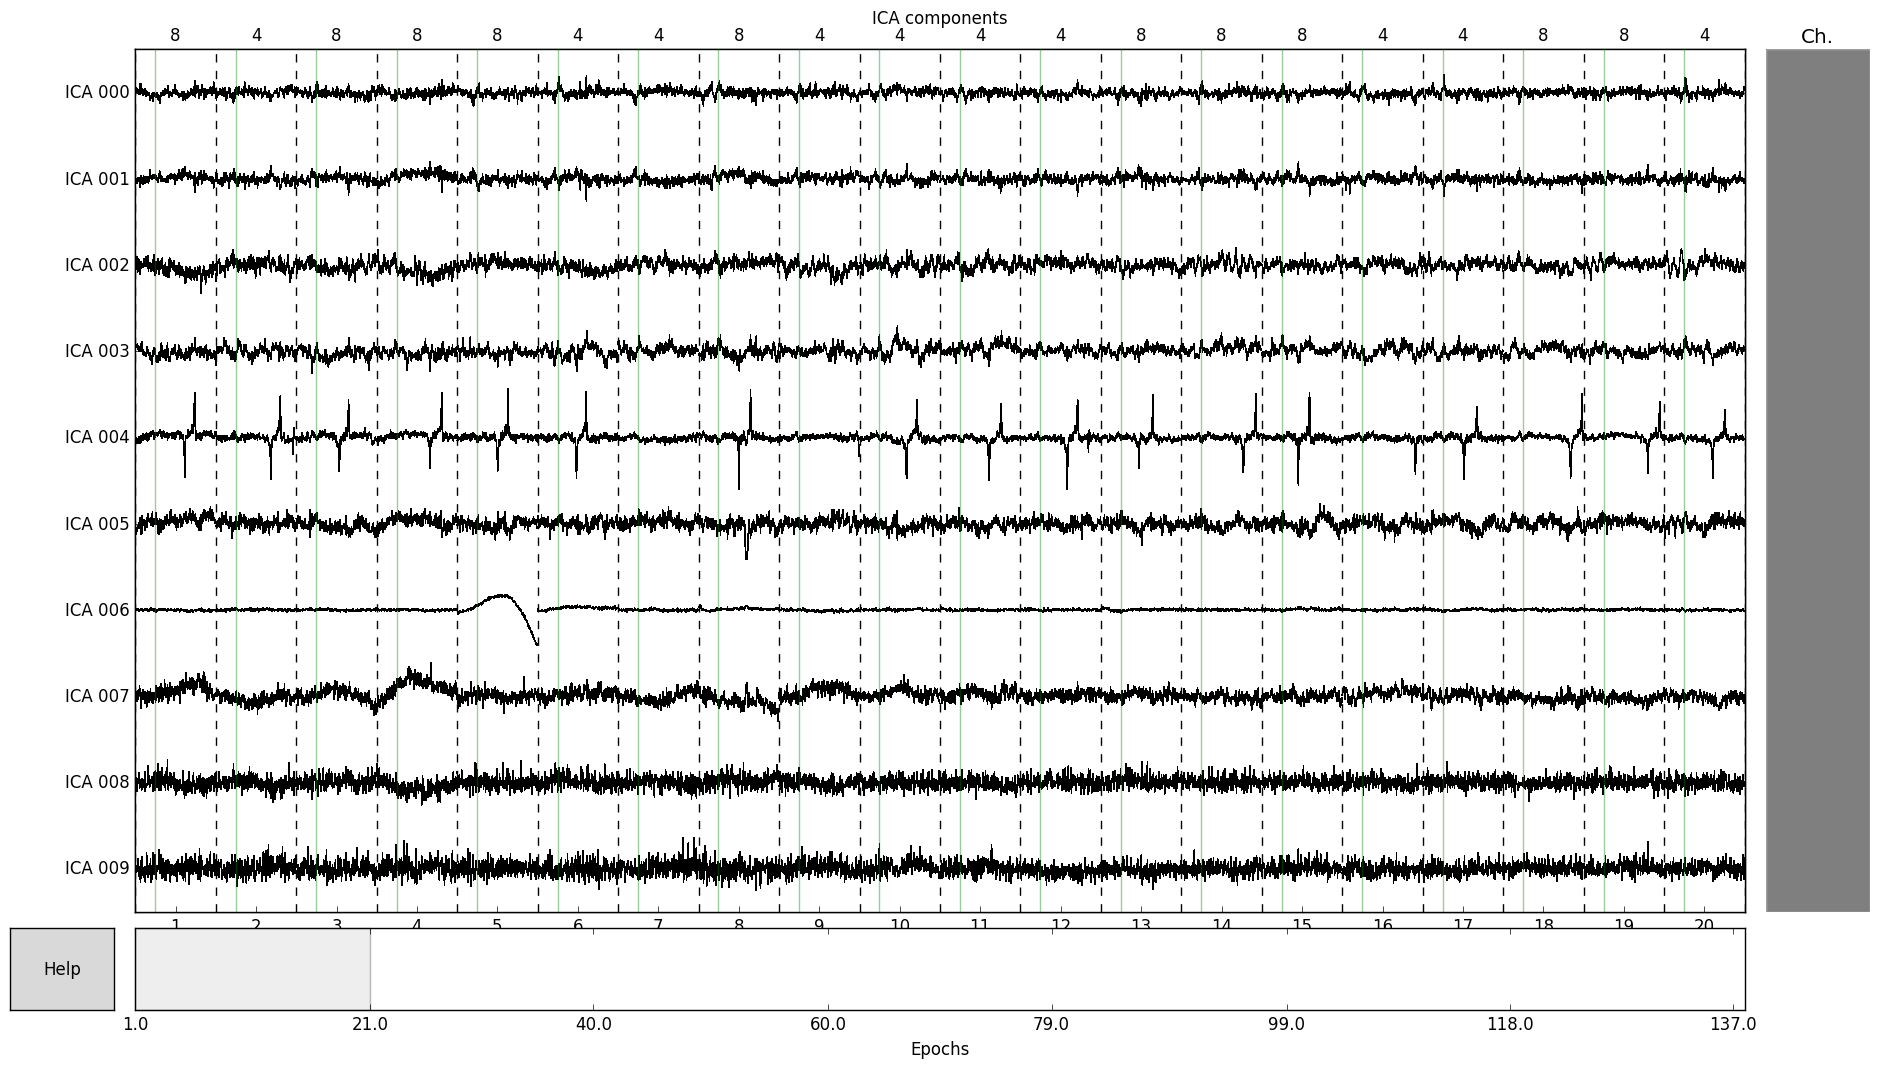

In [66]:
ica.plot_sources(ep, picks=range(10), show=False)

In [67]:
ica

<ICA  |  epochs decomposition, fit (extended-infomax): 34387 samples, 65 components, channels used: "eeg", 5 sources marked for exclusion>

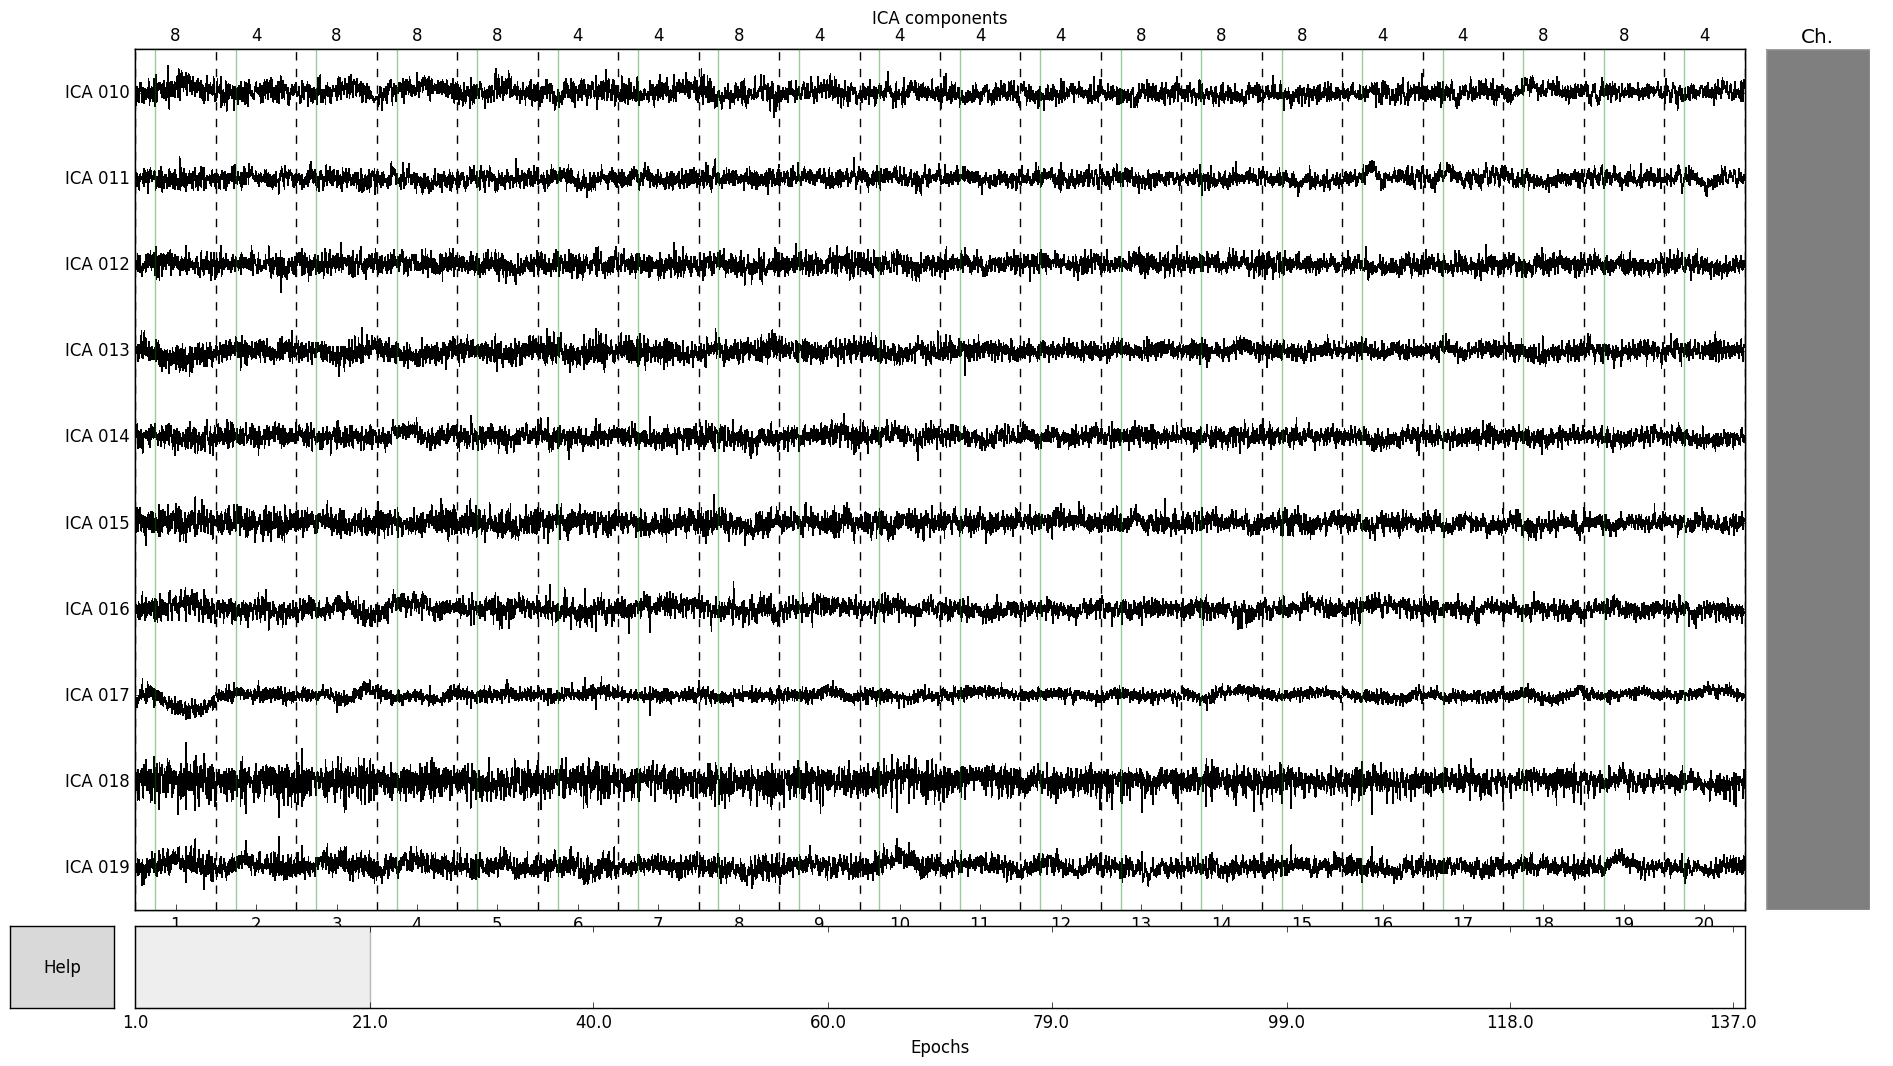

In [70]:
ica.plot_sources(ep, picks=range(10, 20), show=False)

In [71]:
ep = ica.apply(ep)

Transforming to ICA space (65 components)
Zeroing out 5 ICA components


# ERPs

In [75]:
ep['face']._data.shape

(68, 65, 251)

In [80]:
evkd = ep.copy().filter(None, 40).average()

AttributeError: 'Epochs' object has no attribute 'filter'

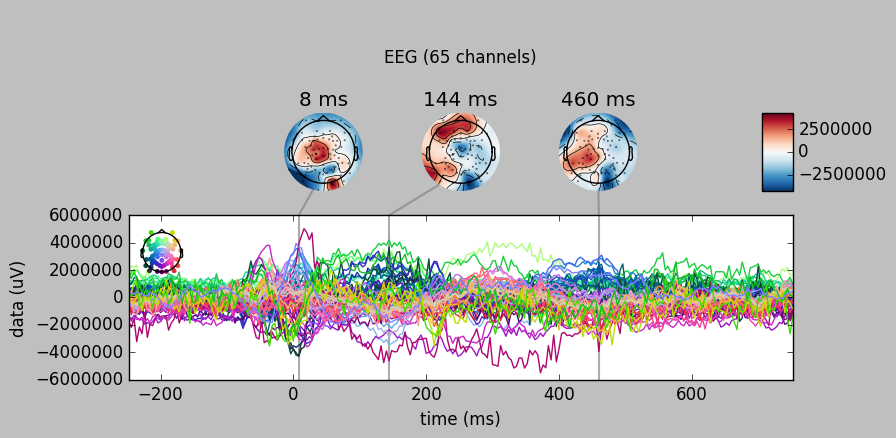

In [83]:
evkd.plot_joint()

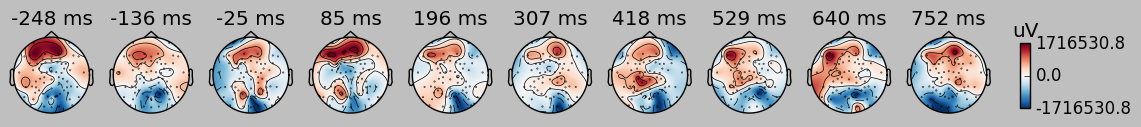

In [92]:
evkd.plot_topomap(show=False)